In [1]:
import pandas as pd

from rdkit import Chem
from rdkit.Chem import rdmolops
from rdkit.Chem import Draw, rdFMCS, AllChem, rdmolops, rdFMCS
from rdkit.Chem import Draw
from rdkit import rdBase
rdBase.DisableLog('rdApp.*')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from rgroupinterm.rgroupenumeration import EnumRGroups
import time
from random import sample

In [2]:
import glob, os
from itertools import combinations 

df = pd.DataFrame()
names = []

# for eg5
dir = 'eg5'
path = f"/zfsdata/data/linde/fep_intermediate_generation/ligands/" 
addendum = '*.sdf'

# # for BACE1
# dir = 'bace_combination'
# path = "/zfsdata/data/linde/Intermediate_generator/data/"
# addendum = 'lig*.sdf'

# # for sars-cov2 protease
# dir = 'DECIMER_results_1697823916'
# path = f"/zfsdata/data/linde/fep_intermediate_generation/ligands/" 
# addendum = '*.mol'


for file in glob.glob(path+dir+'/'+addendum):
    names.append(file.split('/')[-1].split('.')[0])

perts_to_intrap = [[dir, f"{y}~{x}"] for (x, y) in combinations(names, 2)]

Objective: 
- Generate a list of ligand endpoints that represent a range of 'difficult' FEPs
- Depict these endpoints
- Per pair of ligands, generate an intermediate
- Depict all triplets (i.e. endpoints + intermediate)
- Compute some difficulty metric (e.g. LOMAP-Score) per triplet for A->B and A->i->B

In [3]:
def generateIntermediate(liga, ligb):
    """Function for generating a ligand intermediate between two ligand endpoints. Currently 
    only does SMILES-based intermediate generation"""
    # create instance of SMILES-based intermediate generator class, 
    # If insert_small = false, only remove tokens from the larger of the pair. If true, also insert tokens from smaller fragment
    # Takes ~10 minutes for whole set
    generator = EnumRGroups()
    
    # returns df with the generated intermediates
    pair = [liga, ligb]
    
    df_interm, core = generator.generate_intermediates(pair)
    intermediates = df_interm['Intermediate'].tolist()
    # print(generator.multiple)
    # print(2**(len(generator.columns))-2)

    return intermediates, generator.multiple, 2**(len(generator.columns))-2, core

In [7]:
from rgroupinterm.rgroup_highlighting import plot_highlighted
for tgt, pert in [perts_to_intrap[2]]:
    liga, ligb = pert.split("~")
    try:
        liga, ligb = [ Chem.rdmolfiles.SDMolSupplier(f"{path}/{tgt}/{lig}.sdf")[0] for lig in [liga, ligb]]
    except OSError:
        try:
            # naming is inconsistent; try with 'lig_' prefix.
            liga, ligb = [ Chem.rdmolfiles.SDMolSupplier(f"{path}/{tgt}/lig_{lig}.sdf")[0] for lig in [liga, ligb]]
        except OSError:
            # mol file
            liga, ligb = [ Chem.MolFromMolFile(f"{path}/{tgt}/{lig}.mol") for lig in [liga, ligb]]
    all_intermediates, multiple, expected, core = generateIntermediate(liga, ligb)

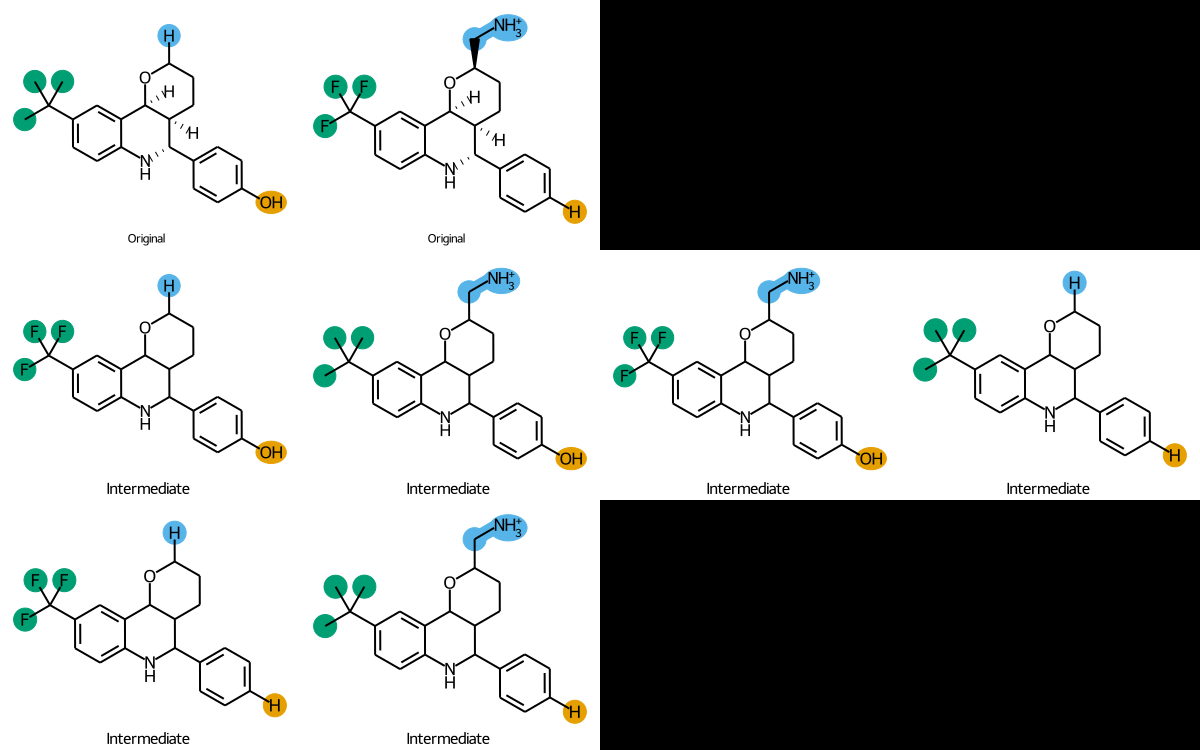

In [8]:
image = plot_highlighted(liga, ligb, all_intermediates, core)
image